# Replication of attack on VoIP end-to-end encrypted messengers

## Loading dataset

First we will try to load our data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

sns.set()  # make plots nicer

np.random.seed(42)  # set seed for reproducibility

Format of the input file is as follows (with examples of data, that can be there):  
**Line indicating spoken phrase:** _Sentence: "She had your dark suit in greasy wash water all year."_  
**Line with information about current transmission** _Packets: 146, Samples: 46797, Samples per packet: 320_  
**Line with data**: _74;ix,hv;"she","had"_ (packet size, phonemes, words)

In [2]:
# data format: name (of csv file); sentence; (packet size, [phonems], [words])
def file_parser(path):
    file = open(path, 'r')
    lines = file.readlines()
    
    file_name = [path.split('/')[-1]]
    sentence = ""
    file_data = []
    
    for line in lines:
        line = line.strip()
        
        # if there are only 2 informations on line and second is h#, then ignore
        # strip line, split primarly on ; secondary on ,
        if (line.startswith('#')):
            if (not sentence):
                sentence = line[len('# Sentence: "'): len(line) - 1]
            continue
        
        line = line.split(';')
        
        if (len(line) == 1):
            #lines containing only their packet size and nothing else, they should be added
            line += [""]
            line += [""]
        
        if (len(line) == 2):
            #this tries to remove most of the silence at the start of the recording
            #if (line[1] == 'h#'):
            #    continue
            line += [""]
        
        line[1] = tuple(line[1].split(','))
        line[2] = tuple(list(map(lambda a: a.strip('"'), line[2].split(','))))
           
        # file_name and author contain duplicate informations, but are kept for readability
        line = file_name + [file_name[0][0:9]] + [sentence] + line
        file_data += [line]

    return pd.DataFrame(file_data, columns=['file', 'speaker', 'sentence', 'packet_size', 'phonemes', 'words'])

def load_files(directory):
    filelist = os.listdir(directory)
    #read them into pandas
    df_list = [file_parser(directory+file) for file in filelist]
    #concatenate them together
    return pd.concat(df_list, ignore_index=True)

In [3]:
#file_parser("./../data/skype_train_data/DR1-FSAH0-SI614.CSV")   

data = load_files("./../data/skype_train_data/")
data

,file,speaker,sentence,packet_size,phonemes,words
0,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,32,"(h#,)","(,)"
1,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,32,"(h#,)","(,)"
2,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,31,"(h#,)","(,)"
3,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,28,"(h#,)","(,)"
4,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,28,"(h#,)","(,)"
...,...,...,...,...,...,...
707433,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,32,"(h#,)","(,)"
707434,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,34,"(h#,)","(,)"
707435,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,39,"(h#,)","(,)"
707436,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,33,"(h#,)","(,)"


For our purposes we've decided to omit beggings and ends of the files as they contain only some silence. Maybe it would be worth investigating what the accuracy would be, had we not remowed these.

Let's convert the `packet_size` from _object_ to _numerical value_ and `file`, `sentence` to the type _category_.

In [4]:
data['packet_size'] = pd.to_numeric(data['packet_size'])

In [5]:
data['file'] = data['file'].astype('category')
data['sentence'] = data['sentence'].astype('category')
#data['speaker'] = data['speaker'].astype('category')

In [6]:
data.dtypes

file           category
speaker          object
sentence       category
packet_size       int64
phonemes         object
words            object
dtype: object

## Exploratory analysis

For most of our exploratory analysis we will use the powerfull tool of `pandas_profilling` which can provide us with many interesting graphs and statistics, which we can use.

Our first step in exploratory analysis will be to just to look at data without modifying anything (expect the column types)

In [7]:
import pandas_profiling as pp
from pandas_profiling import ProfileReport

ProfileReport(data, "First look at data")

From this analysis we can see, that we have 4620 distinct files (which isn't surprising, we already knew that), 462 distinct speakers and 1737 unique sentences. Sadly `pandas_profilling` doesn't seem to be up to this task as converting phonemes and words to cathegorical values breaks `pandas_profilling`. This is caused by current implementation of `pandas` that requires categorical list like objects to be of the same length so it can do the comparison (_categorical.py in func(self, other), lines 70 to 72_).

Now we will get the frequencies of senteces.

In [8]:
frequencies = data[['sentence', 'file']].drop_duplicates(subset=['file'])['sentence'].value_counts()
frequencies

She had your dark suit in greasy wash water all year.                         462
Don't ask me to carry an oily rag like that.                                  461
Growing well-kept gardens is very time consuming.                               7
Correct execution of my instructions is crucial.                                7
Cyclical programs will never compile.                                           7
                                                                             ... 
Sprouted grains and seeds are used in salads and dishes such as chop suey.      1
State numbering laws differ from each other in many ways.                       1
Stay right here where you are, kid, he called.                                  1
Stoneware clay for tiles.                                                       1
"Cable confirmation", it said translated.                                       1
Name: sentence, Length: 1737, dtype: int64

In [9]:
np.asarray(np.unique(frequencies.array.to_numpy(), return_counts=True)).T

array([[   1, 1402],
       [   2,    3],
       [   4,    1],
       [   5,    2],
       [   6,   14],
       [   7,  313],
       [ 461,    1],
       [ 462,    1]], dtype=int64)

We can see, that the sentence column is heavily skewed as 30% of our dataset is composed of sentences, which are spoken only once. 10% takes the sentence _She had your dark suit in greasy wash water all year._ and another 10% takes sentence _Don't ask me to carry an oily rag like that._ The remaining 50% of the data are sentences, that have more than one occurance, but not by a high margin.

Now we can properly convert words and phonemes to their proper type -> category

In [10]:
# this conversion breaks pandas_profiling :(
# actually I know why this breaks profilling, pandas requieres categorical list like structures to be of the same length for reasons unknown
data['phonemes'] = data['phonemes'].astype('category')
data['words'] = data['words'].astype('category')

### Statistic for packet sizes for specific phonemes / words

Now let's look at packet sizes for few select words / phonemes. From the first look at data I would say, that packet sizes for phonemes will be more important for the `skype` dataset and packet sizes for words will be more important for `whatsapp` dataset.<br />
This is because `skype` dataset uses much smaller packet sizes, therefore it is highly probable, that only one phoneme will correspond to only one packet size and the same goes for `whatsapp` dataset, that has much bigger packets and from my observation one packet corresponds to one word.

In [11]:
label_data = data.loc[:, ('packet_size', 'phonemes', 'words', 'sentence')]
label_data

,packet_size,phonemes,words,sentence
0,32,"(h#,)","(,)",She had your dark suit in greasy wash water al...
1,32,"(h#,)","(,)",She had your dark suit in greasy wash water al...
2,31,"(h#,)","(,)",She had your dark suit in greasy wash water al...
3,28,"(h#,)","(,)",She had your dark suit in greasy wash water al...
4,28,"(h#,)","(,)",She had your dark suit in greasy wash water al...
...,...,...,...,...
707433,32,"(h#,)","(,)",Good service should be rewarded by big tips.
707434,34,"(h#,)","(,)",Good service should be rewarded by big tips.
707435,39,"(h#,)","(,)",Good service should be rewarded by big tips.
707436,33,"(h#,)","(,)",Good service should be rewarded by big tips.


In [12]:
len(pd.unique(label_data['phonemes']))

3083

In [13]:
len(pd.unique(label_data['words']))

15713

From this we can see, that we have 3083 unique n-grams of phonemes and 15713 unique n-grams of words.

#### Phonemes

Now we will look at the top most occuring phonemes and define analysis for specific phonemes / words:

In [14]:
label_frequencies = label_data['phonemes'].value_counts()
label_frequencies.head(20)

(h#,)     83174
(s,)      34535
(ae,)     25557
(iy,)     24409
(aa,)     15627
(ao,)     15233
(ay,)     14780
(ih,)     14750
(eh,)     13669
(ix,)     13497
(r,)      13192
(ey,)     12160
(n,)      11982
(z,)      11908
(kcl,)    11581
(l,)      11553
(tcl,)    11412
(ow,)     11284
(sh,)     10634
(axr,)    10402
Name: phonemes, dtype: int64

In [15]:
from IPython.display import display

def get_distribution_info(dataframe, xlabel):
    Q1 = dataframe.packet_size.quantile(0.25)
    Q3 = dataframe.packet_size.quantile(0.75)
    IQR = Q3 - Q1

    print("Current label:\t\t", xlabel)
    print("Total values:", dataframe.packet_size.count())
    print("Lower outsiders:", (dataframe.packet_size < (Q1 - 1.5 * IQR)).sum())
    print("Upper outsiders:", (dataframe.packet_size > (Q3 + 1.5 * IQR)).sum())
    print()
    
    plt.figure()
    dataframe.packet_size.plot.box()
    plt.xlabel(xlabel)
    plt.show()
    plt.figure()
    dataframe.packet_size.plot.hist()
    plt.show()

    #display(dataframe[dataframe.packet_size < (Q1 - 1.5 * IQR)].sort_values('packet_size').head(10))
    #display(dataframe[dataframe.packet_size > (Q3 + 1.5 * IQR)].sort_values('packet_size', ascending=False).head(10))
    
    display(dataframe.sort_values('packet_size').head(10))
    display(dataframe.sort_values('packet_size', ascending=False).head(10))

We will take a look at a few of the most common phonemes (and the most common pair of phonemes) and see whether they are evenly distributed or not at all:

Unique packet values: 59 	Unique words: 1721
Current label:		 ('s',)
Total values: 34535
Lower outsiders: 170
Upper outsiders: 702



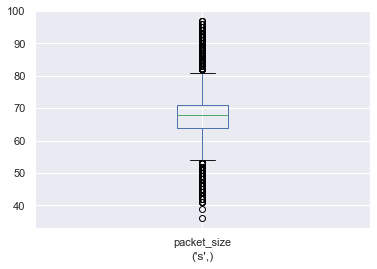

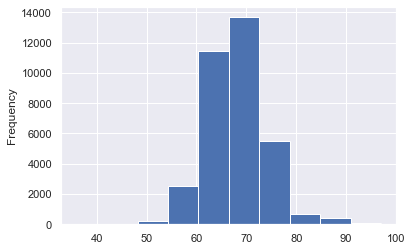

,packet_size,phonemes,words,sentence
641717,36,"(s,)","(audience,)","As coauthors, we presented our new book to the..."
260578,39,"(s,)","(square,)",While waiting for Chipper she crisscrossed the...
358558,41,"(s,)","(miraculous,)",The new birth is miraculous and mysterious.
627649,41,"(s,)","(unions,)",It was most effective against trade unions.
13366,41,"(s,)","(coexist,)",Curiosity and mediocrity seldom coexist.
367750,41,"(s,)","(exquisite,)",Vietnamese cuisine is exquisite.
34800,42,"(s,)","(regulations,)",Etiquette mandates compliance with existing re...
80165,42,"(s,)","(offensive,)",Nothing is as offensive as innocence.
94633,42,"(s,)","(coincided,)",Employee layoffs coincided with the company's ...
279140,42,"(s,)","(ask,)",Don't ask me to carry an oily rag like that.


,packet_size,phonemes,words,sentence
150332,97,"(s,)","(zoologist,)",The easygoing zoologist relaxed throughout the...
379392,97,"(s,)","(progress,)",Scientific progress comes from the development...
82521,97,"(s,)","(strip,)",A smile pulled at the lower strip of adhesive ...
141232,96,"(s,)","(exist,)","Mosquitoes exist in warm, humid climates."
704709,96,"(s,)","(fibrosis,)","Microscopically, there was emphysema, fibrosis..."
367317,96,"(s,)","(snarled,)",She snarled warningly.
546782,96,"(s,)","(ambidextrous,)",Ambidextrous pickpockets accomplish more.
95737,96,"(s,)","(lists,)",The data are presented in lists and tables.
201590,95,"(s,)","(mathews,)","Davy Mathews! It's disgusting, the way you're ..."
674198,95,"(s,)","(greasy,)",She had your dark suit in greasy wash water al...




Unique packet values: 68 	Unique words: 634
Current label:		 ('ae',)
Total values: 25557
Lower outsiders: 96
Upper outsiders: 31



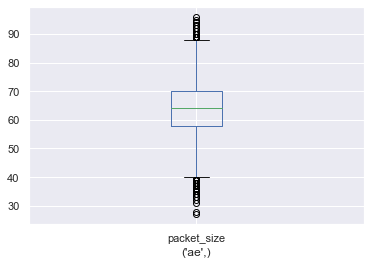

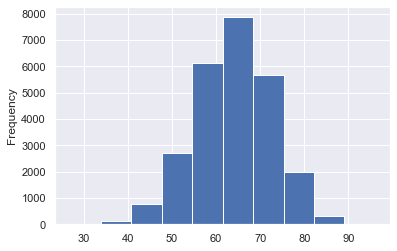

,packet_size,phonemes,words,sentence
22876,27,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
395609,28,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
339010,31,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
408177,32,"(ae,)","(rag,)",Don't ask me to carry an oily rag like that.
359794,33,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
595737,33,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
392205,34,"(ae,)","(mask,)",The prowler wore a ski mask for disguise.
550566,34,"(ae,)","(man,)",For a man of his mass he was curiously short.
297791,34,"(ae,)","(hand,)",Publicity and notoriety go hand in hand.
424915,35,"(ae,)","(rag,)",Don't ask me to carry an oily rag like that.


,packet_size,phonemes,words,sentence
343282,96,"(ae,)","(ask,)",Don't ask me to carry an oily rag like that.
472732,95,"(ae,)","(ask,)",Don't ask me to carry an oily rag like that.
554699,94,"(ae,)","(lack,)",The lack of heat compounded the tenant's griev...
192045,94,"(ae,)","(wagons,)",The wagons were burning fiercely.
400159,93,"(ae,)","(trespassing,)",Trespassing is forbidden and subject to penalty.
479804,93,"(ae,)","(laboratory,)",Thirty-five military and civilian students rec...
373366,92,"(ae,)","(ask,)",Don't ask me to carry an oily rag like that.
125950,92,"(ae,)","(nevada,)",Brush fires are common in the dry underbrush o...
648286,92,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
234698,91,"(ae,)","(rag,)",Don't ask me to carry an oily rag like that.




Unique packet values: 65 	Unique words: 1112
Current label:		 ('iy',)
Total values: 24409
Lower outsiders: 75
Upper outsiders: 35



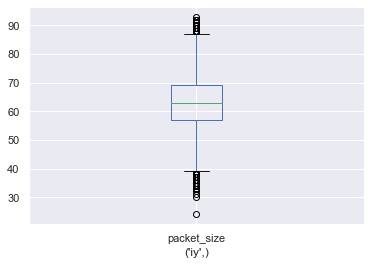

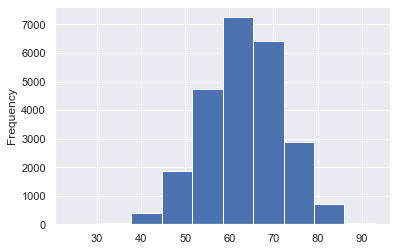

,packet_size,phonemes,words,sentence
168436,24,"(iy,)","(freely,)",Remember to allow identical twins to enter fre...
347218,30,"(iy,)","(mediocrity,)",Curiosity and mediocrity seldom coexist.
551546,31,"(iy,)","(cheese,)",First add milk to the shredded cheese.
565640,32,"(iy,)","(received,)",Al received a joint appointment in the biology...
534973,33,"(iy,)","(cream,)",Birthday parties have cupcakes and ice cream.
400609,33,"(iy,)","(cheese,)",We like bleu cheese but Victor prefers swiss c...
413457,33,"(iy,)","(needs,)",He needs outfielders bad.
185511,33,"(iy,)","(forgery,)",It's hard to tell an original from a forgery.
551545,33,"(iy,)","(cheese,)",First add milk to the shredded cheese.
198889,34,"(iy,)","(eating,)","By eating yogurt, you may live longer."


,packet_size,phonemes,words,sentence
498778,93,"(iy,)","(increases,)",Last year's gas shortage caused steep price in...
125667,92,"(iy,)","(norwegian,)",Norwegian sweaters are made of lamb's wool.
670181,92,"(iy,)","(carry,)",Don't ask me to carry an oily rag like that.
340350,92,"(iy,)","(me,)",Don't ask me to carry an oily rag like that.
504853,92,"(iy,)","(recoiled,)",The barracuda recoiled from the serpent's pois...
247930,91,"(iy,)","(legal,)",Mike was of legal age and presumed able to def...
100581,91,"(iy,)","(oily,)",Don't ask me to carry an oily rag like that.
291004,90,"(iy,)","(greasy,)",She had your dark suit in greasy wash water al...
213678,90,"(iy,)","(eating,)","By eating yogurt, you may live longer."
239406,90,"(iy,)","(cory,)",Cory attacked the project with extra determina...




Unique packet values: 64 	Unique words: 1034
Current label:		 ('kcl', 'k')
Total values: 4488
Lower outsiders: 0
Upper outsiders: 11



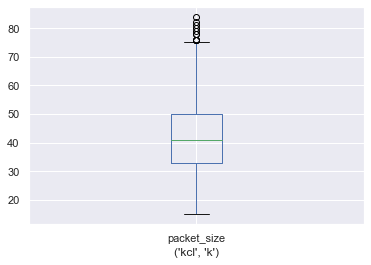

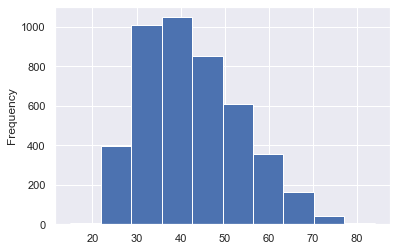

,packet_size,phonemes,words,sentence
114332,15,"(kcl, k)","(clothes,)",She must have put his clothes in the closet.
125419,20,"(kcl, k)","(scalp,)",His scalp was blistered from today's hot sun.
115507,20,"(kcl, k)","(ask,)",Don't ask me to carry an oily rag like that.
653057,20,"(kcl, k)","(walked,)",Samples: he walked in upon her invitation.
580098,21,"(kcl, k)","(perpendicular,)","According to my interpretation of the problem,..."
286306,21,"(kcl, k)","(ask,)",Don't ask me to carry an oily rag like that.
152922,21,"(kcl, k)","(carry,)",Don't ask me to carry an oily rag like that.
36726,21,"(kcl, k)","(make,)",Make it come off all right.
218962,21,"(kcl, k)","(grotesque,)","It was a grotesque hen, five or six feet tall."
304644,22,"(kcl, k)","(check,)",It's illegal to postdate a check.


,packet_size,phonemes,words,sentence
308304,84,"(kcl, k)","(think,)",You think somebody is going to stand up in the...
206900,82,"(kcl, k)","(toxic,)","In developing film, many toxic chemicals are u..."
549208,81,"(kcl, k)","(cooperates,)",Whoever cooperates in finding Nan's cameo will...
606858,80,"(kcl, k)","(coeducational,)",Almost all colleges are now coeducational.
110140,79,"(kcl, k)","(coeducational,)",Almost all colleges are now coeducational.
354283,78,"(kcl, k)","(dark,)",She had your dark suit in greasy wash water al...
171624,78,"(kcl, k)","(clamp,)",Thomas thinks a larger clamp solves the problem.
159135,76,"(kcl, k)","(eccentricity,)",He had accordingly cultivated eccentricity to ...
622964,76,"(kcl, k)","(continuing,)",The continuing modernization of these forces i...
48750,76,"(kcl, k)","(dark,)",She had your dark suit in greasy wash water al...


In [16]:
label_data['phonemes'] = label_data['phonemes'].astype('object')

#change this array for analysis on more values
interesting_phonemes = [("s",), ("ae",), ("iy",), ("kcl", "k")]

for phoneme in interesting_phonemes:
    graph_data = label_data.loc[label_data.phonemes == phoneme]
    print("Unique packet values:", len(pd.unique(graph_data['packet_size'])), "\tUnique words:", len(pd.unique(graph_data['words'])))
    get_distribution_info(graph_data, phoneme)
    print('\n')

label_data['phonemes'] = label_data['phonemes'].astype('category')

From these graphs we can already see a few alarming things. First of all the phonemes sizes are all over the place suggesting, that there shouldn't be much a a correlation between packet size and spoken phonemes. We will try to make further observations taking into account the surrounding phonemes as that should prove more fruitfull than only focusing on phonemes alone.

#### Words

In [17]:
label_frequencies = label_data['words'].value_counts()
label_frequencies.head(20)

(,)          95710
(that,)       9286
(greasy,)     8543
(wash,)       8161
(carry,)      7913
(suit,)       7656
(rag,)        7526
(oily,)       7367
(dark,)       7344
(year,)       7241
(water,)      7049
(ask,)        6178
(she,)        5579
(like,)       5553
(the,)        5508
(had,)        5458
(all,)        5321
(in,)         5263
(don't,)      4576
(to,)         4475
Name: words, dtype: int64

Unique values: 73 	Unique phonemes: 22
Current label:		 ('',)
Total values: 95710
Lower outsiders: 0
Upper outsiders: 3054



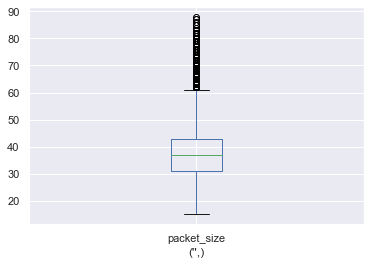

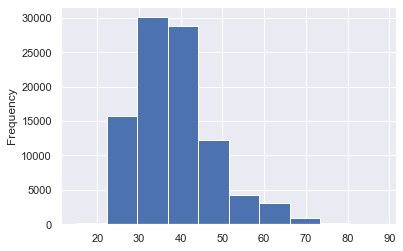

,packet_size,phonemes,words,sentence
680789,15,"(h#,)","(,)",You always come up with pathological examples.
206084,17,"(epi,)","(,)",Don't ask me to carry an oily rag like that.
104111,18,"(h#,)","(,)",Don't ask me to carry an oily rag like that.
532061,19,"(h#,)","(,)",The rose corsage smelled sweet.
551113,19,"(pau,)","(,)","Draw every outer line first, then fill in the ..."
190694,19,"(h#,)","(,)",The Mayan neoclassic scholar disappeared while...
39675,19,"(pau,)","(,)",We will achieve a more vivid sense of what it ...
685508,20,"(h#,)","(,)",Suburban housewives often suffer from the gab ...
167301,20,"(h#,)","(,)",Butterscotch fudge goes well with vanilla ice ...
11210,20,"(h#,)","(,)","As these maladies overlap, so must the cure."


,packet_size,phonemes,words,sentence
88314,88,"(q,)","(,)",She had your dark suit in greasy wash water al...
480398,87,"(q,)","(,)",They often go out in the evening.
95380,87,"(q,)","(,)",She had your dark suit in greasy wash water al...
330298,86,"(q,)","(,)",Correct execution of my instructions is crucial.
277548,85,"(q,)","(,)",She had your dark suit in greasy wash water al...
503667,85,"(q,)","(,)",She had your dark suit in greasy wash water al...
231331,85,"(q,)","(,)",Women may never become completely equal to men.
436842,85,"(q,)","(,)","Draw every outer line first, then fill in the ..."
134161,84,"(pau,)","(,)",Westchester is a county in New York.
42766,83,"(q,)","(,)",Her auburn hair reminded him of autumn leaves.




Unique values: 73 	Unique phonemes: 70
Current label:		 ('that',)
Total values: 9286
Lower outsiders: 0
Upper outsiders: 0



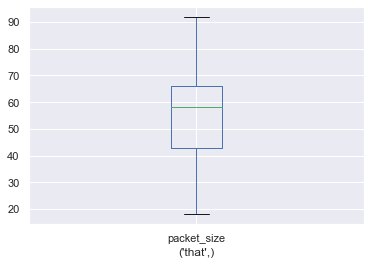

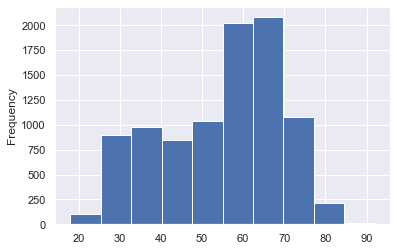

,packet_size,phonemes,words,sentence
592185,18,"(dh,)","(that,)",The proof that you are seeking is not availabl...
503065,20,"(tcl,)","(that,)",Count the number of teaspoons of soysauce that...
66991,21,"(tcl, h#)","(that,)",Don't ask me to carry an oily rag like that.
469032,21,"(tcl, t)","(that,)",Don't ask me to carry an oily rag like that.
294337,21,"(tcl,)","(that,)",Don't ask me to carry an oily rag like that.
196557,21,"(ae, tcl)","(that,)",Don't ask me to carry an oily rag like that.
700074,21,"(tcl,)","(that,)",Don't ask me to carry an oily rag like that.
222944,22,"(q, h#)","(that,)",Don't ask me to carry an oily rag like that.
69951,22,"(dh,)","(that,)",Don't ask me to carry an oily rag like that.
582524,22,"(tcl,)","(that,)",Don't ask me to carry an oily rag like that.


,packet_size,phonemes,words,sentence
648286,92,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
182689,90,"(ae,)","(that,)",You could also say that in these pamphlets is ...
340438,89,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
152995,88,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
30193,88,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
44872,87,"(ae,)","(that,)",I'll have a scoop of that exotic purple and tu...
265414,87,"(dh, ae)","(that,)",Did Shawn catch that big goose without help?
291176,87,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
334473,87,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.
681647,86,"(ae,)","(that,)",Don't ask me to carry an oily rag like that.




Unique values: 72 	Unique phonemes: 37
Current label:		 ('greasy',)
Total values: 8543
Lower outsiders: 365
Upper outsiders: 34



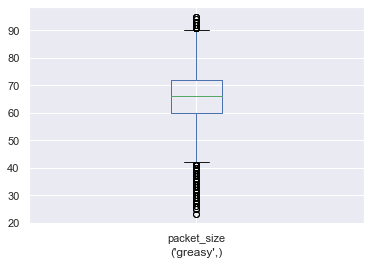

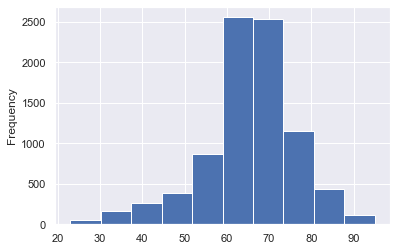

,packet_size,phonemes,words,sentence
272717,23,"(gcl, g)","(greasy,)",She had your dark suit in greasy wash water al...
299964,23,"(gcl, g)","(greasy,)",She had your dark suit in greasy wash water al...
566293,25,"(gcl,)","(greasy,)",She had your dark suit in greasy wash water al...
86512,25,"(gcl, g)","(greasy,)",She had your dark suit in greasy wash water al...
279023,25,"(gcl, g)","(greasy,)",She had your dark suit in greasy wash water al...
331146,26,"(gcl,)","(greasy,)",She had your dark suit in greasy wash water al...
378412,26,"(gcl, g)","(greasy,)",She had your dark suit in greasy wash water al...
142007,27,"(gcl,)","(greasy,)",She had your dark suit in greasy wash water al...
302993,27,"(gcl, g)","(greasy,)",She had your dark suit in greasy wash water al...
98745,27,"(gcl, g)","(greasy,)",She had your dark suit in greasy wash water al...


,packet_size,phonemes,words,sentence
674198,95,"(s,)","(greasy,)",She had your dark suit in greasy wash water al...
665149,95,"(iy, s)","(greasy,)",She had your dark suit in greasy wash water al...
190079,95,"(ix, s)","(greasy,)",She had your dark suit in greasy wash water al...
281850,94,"(s,)","(greasy,)",She had your dark suit in greasy wash water al...
280429,94,"(z,)","(greasy,)",She had your dark suit in greasy wash water al...
166031,93,"(iy, z)","(greasy,)",She had your dark suit in greasy wash water al...
367103,93,"(z,)","(greasy,)",She had your dark suit in greasy wash water al...
468786,93,"(iy, s)","(greasy,)",She had your dark suit in greasy wash water al...
231623,93,"(s,)","(greasy,)",She had your dark suit in greasy wash water al...
545518,93,"(iy, s)","(greasy,)",She had your dark suit in greasy wash water al...




Unique values: 66 	Unique phonemes: 25
Current label:		 ('had', 'your')
Total values: 895
Lower outsiders: 54
Upper outsiders: 2



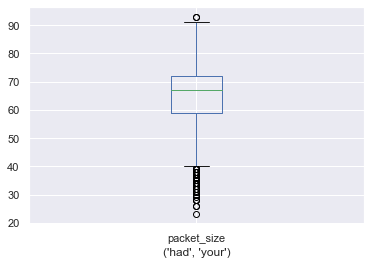

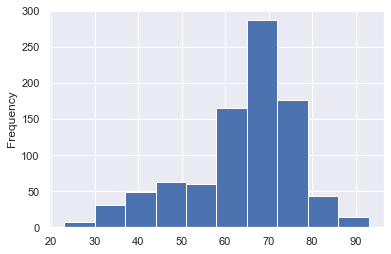

,packet_size,phonemes,words,sentence
272665,23,"(dcl, y)","(had, your)",She had your dark suit in greasy wash water al...
184061,26,"(dcl, jh)","(had, your)",She had your dark suit in greasy wash water al...
331090,26,"(dcl, ch)","(had, your)",She had your dark suit in greasy wash water al...
182321,28,"(dcl, jh)","(had, your)",She had your dark suit in greasy wash water al...
624124,28,"(dcl, jh)","(had, your)",She had your dark suit in greasy wash water al...
25547,28,"(dcl, jh)","(had, your)",She had your dark suit in greasy wash water al...
21243,29,"(dcl, jh)","(had, your)",She had your dark suit in greasy wash water al...
58983,30,"(dcl, jh)","(had, your)",She had your dark suit in greasy wash water al...
38040,30,"(dcl, jh)","(had, your)",She had your dark suit in greasy wash water al...
640708,31,"(dcl, jh)","(had, your)",She had your dark suit in greasy wash water al...


,packet_size,phonemes,words,sentence
109316,93,"(d, y)","(had, your)",She had your dark suit in greasy wash water al...
507189,93,"(jh,)","(had, your)",She had your dark suit in greasy wash water al...
194669,91,"(jh,)","(had, your)",She had your dark suit in greasy wash water al...
140444,91,"(jh,)","(had, your)",She had your dark suit in greasy wash water al...
248958,90,"(jh,)","(had, your)",She had your dark suit in greasy wash water al...
460930,89,"(jh,)","(had, your)",She had your dark suit in greasy wash water al...
643561,89,"(jh,)","(had, your)",She had your dark suit in greasy wash water al...
171831,87,"(d, y)","(had, your)",She had your dark suit in greasy wash water al...
320208,87,"(jh, axr)","(had, your)",She had your dark suit in greasy wash water al...
534305,87,"(jh,)","(had, your)",She had your dark suit in greasy wash water al...


In [18]:
label_data['words'] = label_data['words'].astype('object')

#change this array for analysis on more values
interesting_words = [("",), ("that",), ("greasy",), ("had", "your")]

for word in interesting_words:
    graph_data = label_data.loc[label_data.words == word]
    #graph_data = graph_data.copy() #.loc was somehow acting up and not copying properly
    print("Unique values:", len(pd.unique(graph_data['packet_size'])), "\tUnique phonemes:", len(pd.unique(graph_data['phonemes'])))
    get_distribution_info(graph_data, word)
    print('\n')

label_data['phonemes'] = label_data['phonemes'].astype('category')

We can see, that the distribution is still all over the place, but more concise than for phonemes, which is kinda surprising. But the problem here is that for longer words we have multiple packets that corespond to said word.

### Feature engineering

Our current analysises so far have only taken into account packet_size alone. Now we will foccus on surrounding packet sizes so we can deduce much more information about our packet sizes and their correspondence to phonemes / words.  
So let's look at data once again:

In [19]:
data

,file,speaker,sentence,packet_size,phonemes,words
0,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,32,"(h#,)","(,)"
1,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,32,"(h#,)","(,)"
2,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,31,"(h#,)","(,)"
3,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,28,"(h#,)","(,)"
4,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,28,"(h#,)","(,)"
...,...,...,...,...,...,...
707433,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,32,"(h#,)","(,)"
707434,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,34,"(h#,)","(,)"
707435,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,39,"(h#,)","(,)"
707436,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,33,"(h#,)","(,)"


We will modify our file parsing function to add previous and next packet size to each record.

In [20]:
def file_parser_with_prev_next(path):
    file = open(path, 'r')
    lines = file.readlines()
    
    file_name = [path.split('/')[-1]]
    sentence = ""
    file_data = []
    
    has_value = False
    previous = 0
    
    for line in lines:
        line = line.strip()
        
        # if there are only 2 informations on line and second is h#, then ignore
        # strip line, split primarly on ; secondary on ,
        if (line.startswith('#')):
            if (not sentence):
                sentence = line[len('# Sentence: "'): len(line) - 1]
            continue
        
        line = line.split(';')
        
        if (len(line) == 1):
            #lines containing only their packet size and nothing else, they should be added
            #TODO
            line += [""]
            line += [""]
            #continue
        
        if (len(line) == 2):
            #this tries to remove most of the silence at the start of the recording
            #potentionally harmfull as we shouldn't clean test data this way (we will be reading labels)
            #if (line[1] == 'h#'):
            #    continue
            line += [""]
        
        line[1] = tuple(line[1].split(','))
        line[2] = tuple(list(map(lambda a: a.strip('"'), line[2].split(','))))
        
        if (has_value):
            file_data[-1][4] = line[0]
           
        # file_type and sentence contain duplicate informations, but are kept for readability
        line = file_name + [file_name[0][0:9]] + [sentence] + [previous] + [0] + line
        #adding previous as feature
        previous = line[5]
        file_data += [line]
        
        #adding next frame as feature
        has_value = True
        
        

    return pd.DataFrame(file_data, columns=['file', 'speaker', 'sentence', 'previous_packet', 'next_packet','packet_size', 'phonemes', 'words'])

def load_files_with_prev_next(directory):
    filelist = os.listdir(directory)
    #read them into pandas
    df_list = [file_parser_with_prev_next(directory+file) for file in filelist]
    #concatenate them together
    return pd.concat(df_list, ignore_index=True)

In [21]:
def convert_types(data_frame):
    data_frame['packet_size'] = pd.to_numeric(data_frame['packet_size'])
    data_frame['previous_packet'] = pd.to_numeric(data_frame['previous_packet'])
    data_frame['next_packet'] = pd.to_numeric(data_frame['next_packet'])

    data_frame['file'] = data_frame['file'].astype('category')
    data_frame['sentence'] = data_frame['sentence'].astype('category')
    data_frame['speaker'] = data_frame['speaker'].astype('category')

First we will be trying to explore Skype data set as the aproach, that we will be trying first requires smaller packet sizes (we need to be able to distinguish the word boundaries for our feature columns).

Now we will try to comeup with with new features for our dataset.

The new features we will be considering for our dataset are:
- previous packet_size
- next packet_size
- bigram of previous and current
- bigram of next and current
- trigram of previous and current

In [22]:
skype_data = load_files_with_prev_next("./../data/skype_train_data/")
convert_types(skype_data)
skype_data

,file,speaker,sentence,previous_packet,next_packet,packet_size,phonemes,words
0,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,0,32,32,"(h#,)","(,)"
1,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,32,31,32,"(h#,)","(,)"
2,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,32,28,31,"(h#,)","(,)"
3,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,31,28,28,"(h#,)","(,)"
4,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,28,36,28,"(h#,)","(,)"
...,...,...,...,...,...,...,...,...
707433,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,47,34,32,"(h#,)","(,)"
707434,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,32,39,34,"(h#,)","(,)"
707435,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,34,33,39,"(h#,)","(,)"
707436,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,39,36,33,"(h#,)","(,)"


We will also be considering bigrams of current and previous / next and trigram of (previous, current, next) packet sizes.

In [23]:
def add_surrounding(data_frame):
    data_frame['prev_curr'] = list(zip(data_frame.previous_packet, data_frame.packet_size))
    data_frame['next_curr'] = list(zip(data_frame.next_packet, data_frame.packet_size))
    data_frame['packet_surrounding'] = list(zip(data_frame.previous_packet, data_frame.packet_size, data_frame.next_packet))
    
    #data_frame['prev_curr'] = data_frame['prev_curr'].astype('category')
    #data_frame['next_curr'] = data_frame['next_curr'].astype('category')
    #data_frame['packet_surrounding'] = data_frame['packet_surrounding'].astype('category')

add_surrounding(skype_data)
skype_data.dtypes

file                  category
speaker               category
sentence              category
previous_packet          int64
next_packet              int64
packet_size              int64
phonemes                object
words                   object
prev_curr               object
next_curr               object
packet_surrounding      object
dtype: object

In [24]:
skype_data = skype_data[['file', 'speaker', 'sentence', 'previous_packet', 'next_packet','packet_size', 'prev_curr', 'next_curr', 'packet_surrounding', 'phonemes', 'words']]
skype_data

,file,speaker,sentence,previous_packet,next_packet,packet_size,prev_curr,next_curr,packet_surrounding,phonemes,words
0,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,0,32,32,"(0, 32)","(32, 32)","(0, 32, 32)","(h#,)","(,)"
1,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,32,31,32,"(32, 32)","(31, 32)","(32, 32, 31)","(h#,)","(,)"
2,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,32,28,31,"(32, 31)","(28, 31)","(32, 31, 28)","(h#,)","(,)"
3,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,31,28,28,"(31, 28)","(28, 28)","(31, 28, 28)","(h#,)","(,)"
4,DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,28,36,28,"(28, 28)","(36, 28)","(28, 28, 36)","(h#,)","(,)"
...,...,...,...,...,...,...,...,...,...,...,...
707433,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,47,34,32,"(47, 32)","(34, 32)","(47, 32, 34)","(h#,)","(,)"
707434,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,32,39,34,"(32, 34)","(39, 34)","(32, 34, 39)","(h#,)","(,)"
707435,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,34,33,39,"(34, 39)","(33, 39)","(34, 39, 33)","(h#,)","(,)"
707436,DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,39,36,33,"(39, 33)","(36, 33)","(39, 33, 36)","(h#,)","(,)"


### More exploratory analysis

In [25]:
len(pd.unique(skype_data['packet_surrounding']))

128265

In [26]:
pack_surr_freq = skype_data[['packet_surrounding']].value_counts()
pack_surr_freq

packet_surrounding
(65, 63, 63)          96
(68, 68, 64)          94
(70, 68, 64)          94
(67, 65, 66)          93
(66, 67, 65)          91
                      ..
(57, 43, 72)           1
(57, 43, 70)           1
(57, 43, 69)           1
(57, 43, 61)           1
(0, 20, 28)            1
Length: 128265, dtype: int64

In [27]:
# compute counts of (number of apperances, how many times it's there)
np.asarray(np.unique(pack_surr_freq.array.to_numpy(), return_counts=True)).T

array([[    1, 45148],
       [    2, 22111],
       [    3, 13573],
       [    4,  9053],
       [    5,  6367],
       [    6,  4611],
       [    7,  3661],
       [    8,  2756],
       [    9,  2235],
       [   10,  2003],
       [   11,  1650],
       [   12,  1394],
       [   13,  1191],
       [   14,  1054],
       [   15,   887],
       [   16,   826],
       [   17,   742],
       [   18,   657],
       [   19,   601],
       [   20,   562],
       [   21,   472],
       [   22,   447],
       [   23,   417],
       [   24,   366],
       [   25,   323],
       [   26,   343],
       [   27,   312],
       [   28,   278],
       [   29,   258],
       [   30,   243],
       [   31,   237],
       [   32,   211],
       [   33,   206],
       [   34,   176],
       [   35,   159],
       [   36,   150],
       [   37,   128],
       [   38,   152],
       [   39,   140],
       [   40,   135],
       [   41,   126],
       [   42,   115],
       [   43,   101],
       [   

Now this looks like it could have more promise as these seem way more unique (but this also is a problem in a way, because we won't be able to generalise that easily and our training data will explode). Almost 1/6 of these values are unique and most of them have lower occurence.

But let's try to kick that into overdrive and look at pairs of (trigram, phoneme). 

In [28]:
trigram_freq = skype_data[['packet_surrounding', 'phonemes']].value_counts()
trigram_freq = trigram_freq.copy(deep=True)
trigram_freq

packet_surrounding  phonemes
(38, 37, 0)         (h#,)       54
(0, 30, 28)         (h#,)       52
(0, 29, 29)         (h#,)       51
(30, 29, 29)        (h#,)       51
(32, 30, 31)        (h#,)       50
                                ..
(66, 62, 64)        (s, ux)      1
                    (t,)         1
                    (t, ah)      1
                    (uw,)        1
(0, 20, 28)         (h#,)        1
Length: 538460, dtype: int64

In [29]:
np.asarray(np.unique(trigram_freq.array.to_numpy(), return_counts=True)).T

array([[     1, 459164],
       [     2,  51313],
       [     3,  14231],
       [     4,   5225],
       [     5,   2244],
       [     6,   1287],
       [     7,    923],
       [     8,    659],
       [     9,    531],
       [    10,    439],
       [    11,    352],
       [    12,    313],
       [    13,    254],
       [    14,    199],
       [    15,    188],
       [    16,    148],
       [    17,    129],
       [    18,    114],
       [    19,    103],
       [    20,     87],
       [    21,     57],
       [    22,     71],
       [    23,     56],
       [    24,     48],
       [    25,     40],
       [    26,     34],
       [    27,     35],
       [    28,     32],
       [    29,     22],
       [    30,     19],
       [    31,     22],
       [    32,     17],
       [    33,     16],
       [    34,     11],
       [    35,      9],
       [    36,      8],
       [    37,     13],
       [    38,      7],
       [    39,      7],
       [    40,      5],


In [30]:
trigram_freq = skype_data[['packet_surrounding', 'words']].value_counts()
trigram_freq = trigram_freq.copy(deep=True)
trigram_freq

packet_surrounding  words      
(30, 29, 29)        (,)            56
(30, 31, 31)        (,)            54
(38, 37, 0)         (,)            54
(0, 30, 28)         (,)            52
(0, 29, 29)         (,)            52
                                   ..
(67, 68, 52)        (all, year)     1
                    (,)             1
(67, 68, 51)        (taken,)        1
                    (occurs,)       1
(0, 20, 28)         (,)             1
Length: 620996, dtype: int64

In [31]:
np.asarray(np.unique(trigram_freq.array.to_numpy(), return_counts=True)).T

array([[     1, 593611],
       [     2,  16844],
       [     3,   3617],
       [     4,   1556],
       [     5,    857],
       [     6,    663],
       [     7,    517],
       [     8,    402],
       [     9,    358],
       [    10,    328],
       [    11,    253],
       [    12,    234],
       [    13,    192],
       [    14,    166],
       [    15,    167],
       [    16,    138],
       [    17,    125],
       [    18,    119],
       [    19,    121],
       [    20,     77],
       [    21,     67],
       [    22,     65],
       [    23,     60],
       [    24,     56],
       [    25,     41],
       [    26,     51],
       [    27,     47],
       [    28,     30],
       [    29,     33],
       [    30,     29],
       [    31,     23],
       [    32,     19],
       [    33,     14],
       [    34,     13],
       [    35,     11],
       [    36,     15],
       [    37,     14],
       [    38,     11],
       [    39,      3],
       [    40,      9],


Okay, but this is still worrysome. Even thought we've achieved higher granurality there are still trigrams, that correspond to multiple phoneme (128265 unique `trigrams` vs 538460 unique pairs of `(trigram, phoneme)`.

So let's do a bit more of exploratory analysis with these new features:

In [32]:
phoneme_stat = skype_data.loc[:, ('packet_size', 'packet_surrounding', 'file', 'speaker', 'phonemes', 'words', 'sentence')]
phoneme_stat

,packet_size,packet_surrounding,file,speaker,phonemes,words,sentence
0,32,"(0, 32, 32)",DR1-FCJF0-SA1.CSV,DR1-FCJF0,"(h#,)","(,)",She had your dark suit in greasy wash water al...
1,32,"(32, 32, 31)",DR1-FCJF0-SA1.CSV,DR1-FCJF0,"(h#,)","(,)",She had your dark suit in greasy wash water al...
2,31,"(32, 31, 28)",DR1-FCJF0-SA1.CSV,DR1-FCJF0,"(h#,)","(,)",She had your dark suit in greasy wash water al...
3,28,"(31, 28, 28)",DR1-FCJF0-SA1.CSV,DR1-FCJF0,"(h#,)","(,)",She had your dark suit in greasy wash water al...
4,28,"(28, 28, 36)",DR1-FCJF0-SA1.CSV,DR1-FCJF0,"(h#,)","(,)",She had your dark suit in greasy wash water al...
...,...,...,...,...,...,...,...
707433,32,"(47, 32, 34)",DR8-MTCS0-SX82.CSV,DR8-MTCS0,"(h#,)","(,)",Good service should be rewarded by big tips.
707434,34,"(32, 34, 39)",DR8-MTCS0-SX82.CSV,DR8-MTCS0,"(h#,)","(,)",Good service should be rewarded by big tips.
707435,39,"(34, 39, 33)",DR8-MTCS0-SX82.CSV,DR8-MTCS0,"(h#,)","(,)",Good service should be rewarded by big tips.
707436,33,"(39, 33, 36)",DR8-MTCS0-SX82.CSV,DR8-MTCS0,"(h#,)","(,)",Good service should be rewarded by big tips.


In [33]:
def analyse_phoneme_trigrams(trigram):
    concrete_phoneme = phoneme_stat[phoneme_stat.packet_surrounding == trigram]
    print("Unique values:", len(pd.unique(concrete_phoneme['phonemes'])))
    temp = concrete_phoneme.groupby(by=['phonemes', 'packet_surrounding'])['phonemes'].count()
    print("Total values: ",sum(temp.values))
    display(temp.sort_values(ascending=False))

    temp1 = concrete_phoneme.groupby(by=['phonemes', 'packet_surrounding', 'speaker'])['phonemes'].count()
    print("\nTotal values: ",sum(temp1.values))
    display(temp1.sort_values(ascending=False))
    print("\n")
    
interesting_trigrams = [(68, 68, 64), (65, 63, 63), (67, 65, 66), (66, 67, 65)]
for trigram in interesting_trigrams:
    analyse_phoneme_trigrams(trigram)

Unique values: 40
Total values:  94


phonemes  packet_surrounding
(s,)      (68, 68, 64)          23
(sh,)     (68, 68, 64)          10
(ae,)     (68, 68, 64)           6
(ao,)     (68, 68, 64)           3
(ux,)     (68, 68, 64)           3
(eh,)     (68, 68, 64)           3
(k,)      (68, 68, 64)           2
(m,)      (68, 68, 64)           2
(axr,)    (68, 68, 64)           2
(ay,)     (68, 68, 64)           2
(ey,)     (68, 68, 64)           2
(ih,)     (68, 68, 64)           2
(iy,)     (68, 68, 64)           2
(l,)      (68, 68, 64)           2
(aa,)     (68, 68, 64)           2
(oy,)     (68, 68, 64)           2
(z,)      (68, 68, 64)           2
(r,)      (68, 68, 64)           2
(ow, nx)  (68, 68, 64)           1
(er,)     (68, 68, 64)           1
(z, hh)   (68, 68, 64)           1
(ah, m)   (68, 68, 64)           1
(ax,)     (68, 68, 64)           1
(v, s)    (68, 68, 64)           1
(uh,)     (68, 68, 64)           1
(ch,)     (68, 68, 64)           1
(th,)     (68, 68, 64)           1
(eh, r)   (68, 68, 64)    


Total values:  98


phonemes  packet_surrounding  speaker  
(s,)      (68, 68, 64)        DR4-MTRT0    2
                              DR7-MPFU0    1
(ao,)     (68, 68, 64)        DR2-FMKF0    1
(z, w)    (68, 68, 64)        DR4-FLHD0    1
(s,)      (68, 68, 64)        DR3-MMSM0    1
                                          ..
(pau,)    (68, 68, 64)        DR5-FLMK0    0
                              DR5-FLJG0    0
                              DR5-FLJA0    0
                              DR5-FKKH0    0
(aa,)     (68, 68, 64)        DR1-FCJF0    0
Name: phonemes, Length: 18480, dtype: int64



Unique values: 40
Total values:  96


phonemes   packet_surrounding
(s,)       (65, 63, 63)          13
(sh,)      (65, 63, 63)           6
(ae,)      (65, 63, 63)           5
(ey,)      (65, 63, 63)           5
(r,)       (65, 63, 63)           5
(ao,)      (65, 63, 63)           4
(f,)       (65, 63, 63)           4
(ix,)      (65, 63, 63)           4
(iy,)      (65, 63, 63)           4
(k,)       (65, 63, 63)           3
(t,)       (65, 63, 63)           3
(ay,)      (65, 63, 63)           3
(er,)      (65, 63, 63)           3
(oy,)      (65, 63, 63)           3
(w,)       (65, 63, 63)           2
(hv,)      (65, 63, 63)           2
(aa,)      (65, 63, 63)           2
(th,)      (65, 63, 63)           2
(n,)       (65, 63, 63)           2
(m,)       (65, 63, 63)           1
(s, hh)    (65, 63, 63)           1
(v,)       (65, 63, 63)           1
(ah,)      (65, 63, 63)           1
(ax,)      (65, 63, 63)           1
(s, iy)    (65, 63, 63)           1
(eh, m)    (65, 63, 63)           1
(el,)      (65, 63, 63)           


Total values:  130


phonemes  packet_surrounding  speaker  
(s,)      (65, 63, 63)        DR2-FSCN0    2
(s, iy)   (65, 63, 63)        DR2-FSCN0    2
(s, hh)   (65, 63, 63)        DR2-FSCN0    2
(s, ix)   (65, 63, 63)        DR2-FSCN0    2
(r,)      (65, 63, 63)        DR7-MDPB0    1
                                          ..
(oy,)     (65, 63, 63)        DR5-FBJL0    0
                              DR4-MTRT0    0
                              DR4-MTRC0    0
                              DR4-MTQC0    0
(aa,)     (65, 63, 63)        DR1-FCJF0    0
Name: phonemes, Length: 18480, dtype: int64



Unique values: 46
Total values:  93


phonemes   packet_surrounding
(s,)       (67, 65, 66)          22
(ay,)      (67, 65, 66)           4
(ih,)      (67, 65, 66)           4
(ey,)      (67, 65, 66)           3
(iy,)      (67, 65, 66)           3
(eh,)      (67, 65, 66)           3
(ah,)      (67, 65, 66)           3
(ix,)      (67, 65, 66)           3
(sh,)      (67, 65, 66)           3
(ao,)      (67, 65, 66)           2
(ae,)      (67, 65, 66)           2
(m,)       (67, 65, 66)           2
(f,)       (67, 65, 66)           2
(t,)       (67, 65, 66)           2
(uw,)      (67, 65, 66)           2
(er,)      (67, 65, 66)           2
(el,)      (67, 65, 66)           2
(dh,)      (67, 65, 66)           1
(ch, axr)  (67, 65, 66)           1
(ch, aa)   (67, 65, 66)           1
(y,)       (67, 65, 66)           1
(ch,)      (67, 65, 66)           1
(axr,)     (67, 65, 66)           1
(eh, axr)  (67, 65, 66)           1
(aw,)      (67, 65, 66)           1
(ao, r)    (67, 65, 66)           1
(ao, l)    (67, 65, 66)           


Total values:  101


phonemes  packet_surrounding  speaker  
(s,)      (67, 65, 66)        DR7-MTMN0    2
                              DR2-MMAA0    1
(ao,)     (67, 65, 66)        DR7-MJJM0    1
(s,)      (67, 65, 66)        DR2-MKAH0    1
(iy, ix)  (67, 65, 66)        DR5-MJWG0    1
                                          ..
(iy, n)   (67, 65, 66)        DR5-MDSJ0    0
                              DR5-MDWH0    0
                              DR5-MEGJ0    0
                              DR5-MEWM0    0
(aa,)     (67, 65, 66)        DR1-FCJF0    0
Name: phonemes, Length: 21252, dtype: int64



Unique values: 40
Total values:  91


phonemes  packet_surrounding
(sh,)     (66, 67, 65)          8
(f,)      (66, 67, 65)          7
(ow,)     (66, 67, 65)          6
(ao,)     (66, 67, 65)          5
(s,)      (66, 67, 65)          5
(ah,)     (66, 67, 65)          5
(aa,)     (66, 67, 65)          4
(ae,)     (66, 67, 65)          4
(eh,)     (66, 67, 65)          3
(axr,)    (66, 67, 65)          3
(hh,)     (66, 67, 65)          3
(iy,)     (66, 67, 65)          3
(l,)      (66, 67, 65)          2
(ux,)     (66, 67, 65)          2
(aw,)     (66, 67, 65)          2
(z,)      (66, 67, 65)          2
(ay,)     (66, 67, 65)          2
(t,)      (66, 67, 65)          2
(ih,)     (66, 67, 65)          2
(er,)     (66, 67, 65)          1
(ae, dx)  (66, 67, 65)          1
(d,)      (66, 67, 65)          1
(ay, m)   (66, 67, 65)          1
(ay, er)  (66, 67, 65)          1
(ey,)     (66, 67, 65)          1
(z, pau)  (66, 67, 65)          1
(h#,)     (66, 67, 65)          1
(ix, n)   (66, 67, 65)          1
(z, hh)   (66, 67, 


Total values:  107


phonemes  packet_surrounding  speaker  
(l,)      (66, 67, 65)        DR5-MSDH0    1
(z, pau)  (66, 67, 65)        DR2-MKDT0    1
(aw,)     (66, 67, 65)        DR3-FSJS0    1
(ih,)     (66, 67, 65)        DR2-MPRB0    1
(ao,)     (66, 67, 65)        DR7-MHXL0    1
                                          ..
(n,)      (66, 67, 65)        DR5-FSJG0    0
                              DR5-FSDC0    0
                              DR5-FSAG0    0
                              DR5-FPMY0    0
(aa,)     (66, 67, 65)        DR1-FCJF0    0
Name: phonemes, Length: 18480, dtype: int64

Okay, this will probably still get better results but we may still get mislead by these results (but alteast ~25% contain same information).

I have also tried grouping by ('phonemes', 'packet_surrounding', 'file') to see, if the same phonemes are from the same speakers and that clearly isn't the case.

We will now try something different: we will consider tuple `(phonemes, words)` as our label:

In [34]:
bilabel = skype_data.loc[:, ('packet_size', 'packet_surrounding', 'file', 'speaker', 'sentence', 'phonemes', 'words')]
bilabel['phoneme_word'] = tuple(zip(skype_data.phonemes, skype_data.words))
bilabel

,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
0,32,"(0, 32, 32)",DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,"(h#,)","(,)","((h#,), (,))"
1,32,"(32, 32, 31)",DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,"(h#,)","(,)","((h#,), (,))"
2,31,"(32, 31, 28)",DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,"(h#,)","(,)","((h#,), (,))"
3,28,"(31, 28, 28)",DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,"(h#,)","(,)","((h#,), (,))"
4,28,"(28, 28, 36)",DR1-FCJF0-SA1.CSV,DR1-FCJF0,She had your dark suit in greasy wash water al...,"(h#,)","(,)","((h#,), (,))"
...,...,...,...,...,...,...,...,...
707433,32,"(47, 32, 34)",DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,"(h#,)","(,)","((h#,), (,))"
707434,34,"(32, 34, 39)",DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,"(h#,)","(,)","((h#,), (,))"
707435,39,"(34, 39, 33)",DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,"(h#,)","(,)","((h#,), (,))"
707436,33,"(39, 33, 36)",DR8-MTCS0-SX82.CSV,DR8-MTCS0,Good service should be rewarded by big tips.,"(h#,)","(,)","((h#,), (,))"


In [35]:
len(pd.unique(bilabel['phoneme_word']))

87741

Now this is interesting, we can see, that in our dataset we have 87741 unique pairs of (phonemes, words) (original statistics are: 3083 unique n-grams of phonemes and 15713 unique n-grams of words).

In [36]:
bilabel_frequencies = bilabel['phoneme_word'].value_counts()
bilabel_frequencies.head(20)

((h#,), (,))          83174
((pau,), (,))          7653
((ae,), (that,))       4371
((ae,), (rag,))        3544
((ae,), (ask,))        3046
((ao,), (all,))        3006
((sh,), (she,))        2933
((q,), (,))            2833
((s,), (suit,))        2735
((ux,), (suit,))       2710
((oy,), (oily,))       2612
((iy,), (greasy,))     2350
((ow,), (don't,))      2305
((aa,), (dark,))       2088
((ay,), (like,))       2046
((y,), (year,))        1990
((w,), (wash,))        1946
((sh,), (wash,))       1855
((r,), (rag,))         1809
((ae,), (had,))        1763
Name: phoneme_word, dtype: int64

These graphs only show values for `packet_size` and not the trigrams of values :(

Unique trigram values: 21904 	Unique packet size values: 65
Current label:		 (('h#',), ('',))
Total values: 83174
Lower outsiders: 0
Upper outsiders: 2475



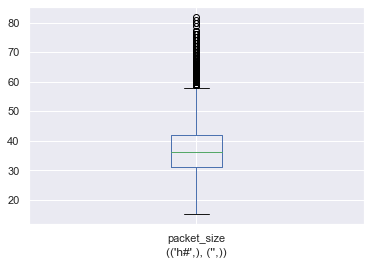

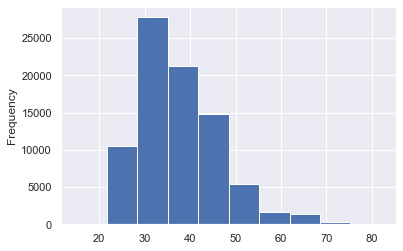

,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
680789,15,"(51, 15, 31)",DR8-FJRB0-SX222.CSV,DR8-FJRB0,You always come up with pathological examples.,"(h#,)","(,)","((h#,), (,))"
104111,18,"(64, 18, 40)",DR2-MDLC2-SA2.CSV,DR2-MDLC2,Don't ask me to carry an oily rag like that.,"(h#,)","(,)","((h#,), (,))"
532061,19,"(38, 19, 26)",DR6-MCAE0-SX277.CSV,DR6-MCAE0,The rose corsage smelled sweet.,"(h#,)","(,)","((h#,), (,))"
190694,19,"(30, 19, 44)",DR3-FLTM0-SX170.CSV,DR3-FLTM0,The Mayan neoclassic scholar disappeared while...,"(h#,)","(,)","((h#,), (,))"
181424,20,"(38, 20, 30)",DR3-FGCS0-SI2116.CSV,DR3-FGCS0,Is there any word you would like to offer in y...,"(h#,)","(,)","((h#,), (,))"
685508,20,"(31, 20, 23)",DR8-FNKL0-SX442.CSV,DR8-FNKL0,Suburban housewives often suffer from the gab ...,"(h#,)","(,)","((h#,), (,))"
596143,20,"(30, 20, 30)",DR7-MBML0-SX179.CSV,DR7-MBML0,We could barely see the fjords through the sno...,"(h#,)","(,)","((h#,), (,))"
627952,20,"(27, 20, 28)",DR7-MHXL0-SX152.CSV,DR7-MHXL0,"Mosquitoes exist in warm, humid climates.","(h#,)","(,)","((h#,), (,))"
495190,20,"(28, 20, 36)",DR5-MTDP0-SX351.CSV,DR5-MTDP0,The new suburbanites worked hard on refurbishi...,"(h#,)","(,)","((h#,), (,))"
11210,20,"(36, 20, 25)",DR1-FMEM0-SI1377.CSV,DR1-FMEM0,"As these maladies overlap, so must the cure.","(h#,)","(,)","((h#,), (,))"


,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
581616,82,"(62, 82, 68)",DR7-FPAB1-SX121.CSV,DR7-FPAB1,Trespassing is forbidden and subject to penalty.,"(h#,)","(,)","((h#,), (,))"
37838,81,"(69, 81, 65)",DR1-MMRP0-SX54.CSV,DR1-MMRP0,The eastern coast is a place for pure pleasure...,"(h#,)","(,)","((h#,), (,))"
473438,80,"(69, 80, 62)",DR5-MPMB0-SI2131.CSV,DR5-MPMB0,You had to be stupid or crazy or immortal.,"(h#,)","(,)","((h#,), (,))"
180975,80,"(62, 80, 45)",DR3-FGCS0-SA1.CSV,DR3-FGCS0,She had your dark suit in greasy wash water al...,"(h#,)","(,)","((h#,), (,))"
110670,79,"(51, 79, 67)",DR2-MDWD0-SX90.CSV,DR2-MDWD0,The Thinker is a famous sculpture.,"(h#,)","(,)","((h#,), (,))"
50169,77,"(70, 77, 44)",DR1-MTJS0-SA1.CSV,DR1-MTJS0,She had your dark suit in greasy wash water al...,"(h#,)","(,)","((h#,), (,))"
355328,77,"(60, 77, 64)",DR4-MLEL0-SX256.CSV,DR4-MLEL0,The irate actor stomped away idiotically.,"(h#,)","(,)","((h#,), (,))"
31119,77,"(78, 77, 68)",DR1-MJWT0-SX211.CSV,DR1-MJWT0,Only the best players enjoy popularity.,"(h#,)","(,)","((h#,), (,))"
587829,76,"(69, 76, 64)",DR7-FVKB0-SX349.CSV,DR7-FVKB0,The preschooler couldn't verbalize her feeling...,"(h#,)","(,)","((h#,), (,))"
35447,76,"(66, 76, 60)",DR1-MMGG0-SI1709.CSV,DR1-MMGG0,"Those lovely whorls, he chortled.","(h#,)","(,)","((h#,), (,))"




Unique trigram values: 6104 	Unique packet size values: 63
Current label:		 (('pau',), ('',))
Total values: 7653
Lower outsiders: 0
Upper outsiders: 74



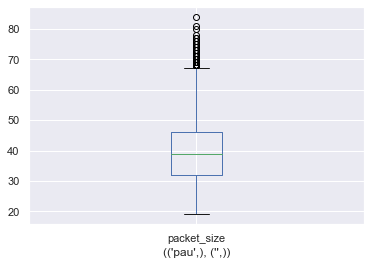

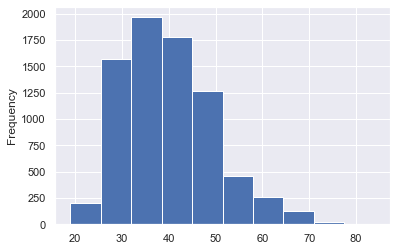

,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
551113,19,"(33, 19, 27)",DR6-MSDS0-SX267.CSV,DR6-MSDS0,"Draw every outer line first, then fill in the ...","(pau,)","(,)","((pau,), (,))"
39675,19,"(23, 19, 24)",DR1-MPGR0-SI1410.CSV,DR1-MPGR0,We will achieve a more vivid sense of what it ...,"(pau,)","(,)","((pau,), (,))"
290028,20,"(25, 20, 28)",DR4-FBMJ0-SI815.CSV,DR4-FBMJ0,Push back up and repeat.,"(pau,)","(,)","((pau,), (,))"
380943,20,"(25, 20, 26)",DR4-MSMC0-SI647.CSV,DR4-MSMC0,"Below is a specific guide, keyed to the calendar.","(pau,)","(,)","((pau,), (,))"
421861,21,"(28, 21, 27)",DR5-FSAG0-SI1323.CSV,DR5-FSAG0,Lousiness is a prerequisite for epidemic typhus.,"(pau,)","(,)","((pau,), (,))"
290214,21,"(31, 21, 30)",DR4-FBMJ0-SX156.CSV,DR4-FBMJ0,Our experiment's positive outcome was unexpected.,"(pau,)","(,)","((pau,), (,))"
358563,21,"(40, 21, 29)",DR4-MLJH0-SI694.CSV,DR4-MLJH0,The new birth is miraculous and mysterious.,"(pau,)","(,)","((pau,), (,))"
391310,21,"(36, 21, 33)",DR4-MTRT0-SI1227.CSV,DR4-MTRT0,"From it, spokes of order and degree led to the...","(pau,)","(,)","((pau,), (,))"
39677,21,"(24, 21, 33)",DR1-MPGR0-SI1410.CSV,DR1-MPGR0,We will achieve a more vivid sense of what it ...,"(pau,)","(,)","((pau,), (,))"
440764,21,"(22, 21, 31)",DR5-MDHL0-SI809.CSV,DR5-MDHL0,Topography -- topography is very important.,"(pau,)","(,)","((pau,), (,))"


,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
134161,84,"(55, 84, 65)",DR2-MMAA0-SX125.CSV,DR2-MMAA0,Westchester is a county in New York.,"(pau,)","(,)","((pau,), (,))"
30496,81,"(75, 81, 67)",DR1-MJWT0-SI1381.CSV,DR1-MJWT0,"But briefly, the topping configuration must be...","(pau,)","(,)","((pau,), (,))"
504356,80,"(74, 80, 63)",DR5-MWSH0-SI796.CSV,DR5-MWSH0,"The filtered air benefits allergies, asthma, s...","(pau,)","(,)","((pau,), (,))"
581337,78,"(74, 78, 50)",DR7-FPAB1-SI841.CSV,DR7-FPAB1,Every single problem touched on thus far is re...,"(pau,)","(,)","((pau,), (,))"
609901,77,"(72, 77, 54)",DR7-MDLC1-SX175.CSV,DR7-MDLC1,Severe myopia contributed to Ron's inferiority...,"(pau,)","(,)","((pau,), (,))"
32454,77,"(62, 77, 75)",DR1-MKLS0-SI2067.CSV,DR1-MKLS0,"Yeah, seems so, don't it, the boy laughed, hug...","(pau,)","(,)","((pau,), (,))"
472852,76,"(68, 76, 65)",DR5-MPMB0-SA2.CSV,DR5-MPMB0,Don't ask me to carry an oily rag like that.,"(pau,)","(,)","((pau,), (,))"
474866,76,"(72, 76, 65)",DR5-MPMB0-SX61.CSV,DR5-MPMB0,Chocolate and roses never fail as a romantic g...,"(pau,)","(,)","((pau,), (,))"
437190,76,"(70, 76, 81)",DR5-MCHL0-SX447.CSV,DR5-MCHL0,First add milk to the shredded cheese.,"(pau,)","(,)","((pau,), (,))"
461468,75,"(70, 75, 61)",DR5-MJWG0-SI813.CSV,DR5-MJWG0,"Push-ups: push-ups are essential, but few have...","(pau,)","(,)","((pau,), (,))"




Unique trigram values: 3945 	Unique packet size values: 61
Current label:		 (('ae',), ('that',))
Total values: 4371
Lower outsiders: 37
Upper outsiders: 10



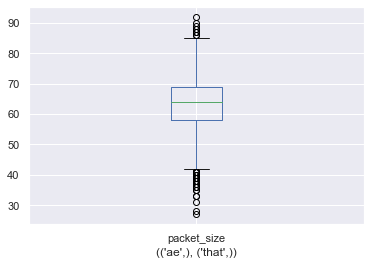

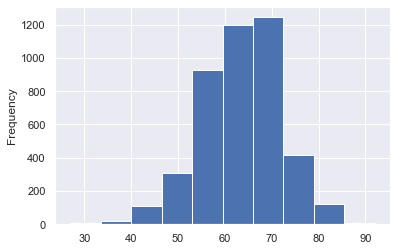

,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
22876,27,"(63, 27, 45)",DR1-MDAC0-SA2.CSV,DR1-MDAC0,Don't ask me to carry an oily rag like that.,"(ae,)","(that,)","((ae,), (that,))"
395609,28,"(46, 28, 40)",DR5-FCDR1-SA2.CSV,DR5-FCDR1,Don't ask me to carry an oily rag like that.,"(ae,)","(that,)","((ae,), (that,))"
339010,31,"(62, 31, 39)",DR4-MJLB0-SA2.CSV,DR4-MJLB0,Don't ask me to carry an oily rag like that.,"(ae,)","(that,)","((ae,), (that,))"
595737,33,"(52, 33, 44)",DR7-MBML0-SA2.CSV,DR7-MBML0,Don't ask me to carry an oily rag like that.,"(ae,)","(that,)","((ae,), (that,))"
359794,33,"(71, 33, 39)",DR4-MLSH0-SA2.CSV,DR4-MLSH0,Don't ask me to carry an oily rag like that.,"(ae,)","(that,)","((ae,), (that,))"
539883,35,"(51, 35, 36)",DR6-MKES0-SA2.CSV,DR6-MKES0,Don't ask me to carry an oily rag like that.,"(ae,)","(that,)","((ae,), (that,))"
341967,35,"(53, 35, 57)",DR4-MJMM0-SA2.CSV,DR4-MJMM0,Don't ask me to carry an oily rag like that.,"(ae,)","(that,)","((ae,), (that,))"
539884,36,"(35, 36, 67)",DR6-MKES0-SA2.CSV,DR6-MKES0,Don't ask me to carry an oily rag like that.,"(ae,)","(that,)","((ae,), (that,))"
353032,36,"(52, 36, 48)",DR4-MLBC0-SA2.CSV,DR4-MLBC0,Don't ask me to carry an oily rag like that.,"(ae,)","(that,)","((ae,), (that,))"
198164,36,"(56, 36, 49)",DR3-FSJW0-SA2.CSV,DR3-FSJW0,Don't ask me to carry an oily rag like that.,"(ae,)","(that,)","((ae,), (that,))"


,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
648286,92,"(73, 92, 68)",DR7-MREM0-SA2.CSV,DR7-MREM0,Don't ask me to carry an oily rag like that.,"(ae,)","(that,)","((ae,), (that,))"
182689,90,"(78, 90, 66)",DR3-FGRW0-SI1152.CSV,DR3-FGRW0,You could also say that in these pamphlets is ...,"(ae,)","(that,)","((ae,), (that,))"
340438,89,"(76, 89, 84)",DR4-MJLS0-SA2.CSV,DR4-MJLS0,Don't ask me to carry an oily rag like that.,"(ae,)","(that,)","((ae,), (that,))"
30193,88,"(67, 88, 76)",DR1-MJWT0-SA2.CSV,DR1-MJWT0,Don't ask me to carry an oily rag like that.,"(ae,)","(that,)","((ae,), (that,))"
152995,88,"(63, 88, 70)",DR2-MRJM0-SA2.CSV,DR2-MRJM0,Don't ask me to carry an oily rag like that.,"(ae,)","(that,)","((ae,), (that,))"
44872,87,"(77, 87, 72)",DR1-MRCG0-SX348.CSV,DR1-MRCG0,I'll have a scoop of that exotic purple and tu...,"(ae,)","(that,)","((ae,), (that,))"
291176,87,"(66, 87, 73)",DR4-FCAG0-SA2.CSV,DR4-FCAG0,Don't ask me to carry an oily rag like that.,"(ae,)","(that,)","((ae,), (that,))"
334473,87,"(64, 87, 70)",DR4-MJDC0-SA2.CSV,DR4-MJDC0,Don't ask me to carry an oily rag like that.,"(ae,)","(that,)","((ae,), (that,))"
550225,86,"(70, 86, 70)",DR6-MSDS0-SA2.CSV,DR6-MSDS0,Don't ask me to carry an oily rag like that.,"(ae,)","(that,)","((ae,), (that,))"
681647,86,"(80, 86, 71)",DR8-FKLH0-SA2.CSV,DR8-FKLH0,Don't ask me to carry an oily rag like that.,"(ae,)","(that,)","((ae,), (that,))"




Unique trigram values: 2163 	Unique packet size values: 31
Current label:		 (('s',), ('suit',))
Total values: 2735
Lower outsiders: 2
Upper outsiders: 7



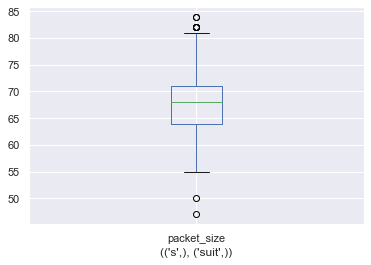

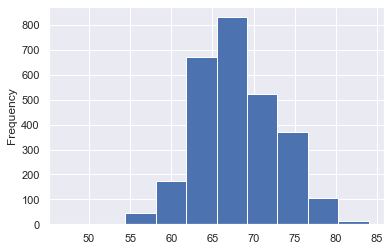

,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
21274,47,"(58, 47, 64)",DR1-MCPM0-SA1.CSV,DR1-MCPM0,She had your dark suit in greasy wash water al...,"(s,)","(suit,)","((s,), (suit,))"
93952,50,"(63, 50, 68)",DR2-MBJV0-SA1.CSV,DR2-MBJV0,She had your dark suit in greasy wash water al...,"(s,)","(suit,)","((s,), (suit,))"
520414,55,"(68, 55, 67)",DR6-FSBK0-SA1.CSV,DR6-FSBK0,She had your dark suit in greasy wash water al...,"(s,)","(suit,)","((s,), (suit,))"
304739,55,"(63, 55, 62)",DR4-FPAF0-SA1.CSV,DR4-FPAF0,She had your dark suit in greasy wash water al...,"(s,)","(suit,)","((s,), (suit,))"
505366,55,"(64, 55, 60)",DR6-FAPB0-SA1.CSV,DR6-FAPB0,She had your dark suit in greasy wash water al...,"(s,)","(suit,)","((s,), (suit,))"
8960,55,"(60, 55, 79)",DR1-FKFB0-SA1.CSV,DR1-FKFB0,She had your dark suit in greasy wash water al...,"(s,)","(suit,)","((s,), (suit,))"
173410,55,"(67, 55, 65)",DR3-FCKE0-SA1.CSV,DR3-FCKE0,She had your dark suit in greasy wash water al...,"(s,)","(suit,)","((s,), (suit,))"
649549,55,"(67, 55, 63)",DR7-MRLJ1-SA1.CSV,DR7-MRLJ1,She had your dark suit in greasy wash water al...,"(s,)","(suit,)","((s,), (suit,))"
553357,56,"(63, 56, 65)",DR6-MSMR0-SA1.CSV,DR6-MSMR0,She had your dark suit in greasy wash water al...,"(s,)","(suit,)","((s,), (suit,))"
646483,56,"(69, 56, 64)",DR7-MPFU0-SA1.CSV,DR7-MPFU0,She had your dark suit in greasy wash water al...,"(s,)","(suit,)","((s,), (suit,))"


,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
131916,84,"(69, 84, 79)",DR2-MKJO0-SA1.CSV,DR2-MKJO0,She had your dark suit in greasy wash water al...,"(s,)","(suit,)","((s,), (suit,))"
41926,84,"(73, 84, 70)",DR1-MRAI0-SA1.CSV,DR1-MRAI0,She had your dark suit in greasy wash water al...,"(s,)","(suit,)","((s,), (suit,))"
343154,82,"(71, 82, 71)",DR4-MJPM1-SA1.CSV,DR4-MJPM1,She had your dark suit in greasy wash water al...,"(s,)","(suit,)","((s,), (suit,))"
80424,82,"(63, 82, 64)",DR2-FMKF0-SA1.CSV,DR2-FMKF0,She had your dark suit in greasy wash water al...,"(s,)","(suit,)","((s,), (suit,))"
628709,82,"(62, 82, 72)",DR7-MJAI0-SA1.CSV,DR7-MJAI0,She had your dark suit in greasy wash water al...,"(s,)","(suit,)","((s,), (suit,))"
660475,82,"(59, 82, 71)",DR7-MTER0-SA1.CSV,DR7-MTER0,She had your dark suit in greasy wash water al...,"(s,)","(suit,)","((s,), (suit,))"
563031,82,"(69, 82, 68)",DR7-FCRZ0-SA1.CSV,DR7-FCRZ0,She had your dark suit in greasy wash water al...,"(s,)","(suit,)","((s,), (suit,))"
508910,81,"(69, 81, 70)",DR6-FHXS0-SA1.CSV,DR6-FHXS0,She had your dark suit in greasy wash water al...,"(s,)","(suit,)","((s,), (suit,))"
315561,81,"(80, 81, 74)",DR4-MCDR0-SA1.CSV,DR4-MCDR0,She had your dark suit in greasy wash water al...,"(s,)","(suit,)","((s,), (suit,))"
147956,81,"(75, 81, 75)",DR2-MRGS0-SA1.CSV,DR2-MRGS0,She had your dark suit in greasy wash water al...,"(s,)","(suit,)","((s,), (suit,))"




Unique trigram values: 635 	Unique packet size values: 50
Current label:		 (('',), ('',))
Total values: 652
Lower outsiders: 0
Upper outsiders: 0



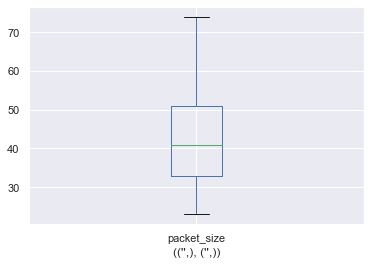

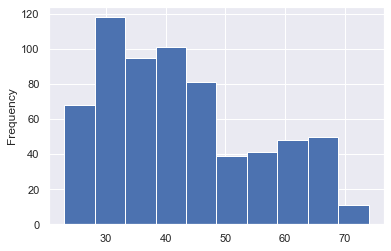

,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
51639,23,"(28, 23, 27)",DR1-MTJS0-SX382.CSV,DR1-MTJS0,George is paranoid about a future gas shortage.,"(,)","(,)","((,), (,))"
480109,23,"(28, 23, 32)",DR5-MRKM0-SI637.CSV,DR5-MRKM0,He enlisted a staff of loyal experts and of ma...,"(,)","(,)","((,), (,))"
591179,24,"(32, 24, 25)",DR7-MAEO0-SX426.CSV,DR7-MAEO0,A moth zig-zagged along the path through Otto'...,"(,)","(,)","((,), (,))"
554298,25,"(28, 25, 0)",DR6-MSMR0-SX145.CSV,DR6-MSMR0,Too much curiosity can get you into trouble.,"(,)","(,)","((,), (,))"
591180,25,"(24, 25, 27)",DR7-MAEO0-SX426.CSV,DR7-MAEO0,A moth zig-zagged along the path through Otto'...,"(,)","(,)","((,), (,))"
279237,25,"(26, 25, 29)",DR3-MTPG0-SA2.CSV,DR3-MTPG0,Don't ask me to carry an oily rag like that.,"(,)","(,)","((,), (,))"
479437,25,"(35, 25, 30)",DR5-MRKM0-SA2.CSV,DR5-MRKM0,Don't ask me to carry an oily rag like that.,"(,)","(,)","((,), (,))"
591186,25,"(28, 25, 33)",DR7-MAEO0-SX426.CSV,DR7-MAEO0,A moth zig-zagged along the path through Otto'...,"(,)","(,)","((,), (,))"
408065,25,"(30, 25, 27)",DR5-FJXM0-SA2.CSV,DR5-FJXM0,Don't ask me to carry an oily rag like that.,"(,)","(,)","((,), (,))"
183177,25,"(0, 25, 28)",DR3-FGRW0-SX162.CSV,DR3-FGRW0,Her auburn hair reminded him of autumn leaves.,"(,)","(,)","((,), (,))"


,packet_size,packet_surrounding,file,speaker,sentence,phonemes,words,phoneme_word
59350,74,"(65, 74, 71)",DR2-FAJW0-SI1263.CSV,DR2-FAJW0,Both have excellent integration of their fisca...,"(,)","(,)","((,), (,))"
364409,71,"(61, 71, 64)",DR4-MMGC0-SA2.CSV,DR4-MMGC0,Don't ask me to carry an oily rag like that.,"(,)","(,)","((,), (,))"
59351,71,"(74, 71, 68)",DR2-FAJW0-SI1263.CSV,DR2-FAJW0,Both have excellent integration of their fisca...,"(,)","(,)","((,), (,))"
100281,71,"(67, 71, 69)",DR2-MDEM0-SA1.CSV,DR2-MDEM0,She had your dark suit in greasy wash water al...,"(,)","(,)","((,), (,))"
355656,70,"(64, 70, 64)",DR4-MLEL0-SX436.CSV,DR4-MLEL0,Please sing just the club theme.,"(,)","(,)","((,), (,))"
479444,70,"(48, 70, 55)",DR5-MRKM0-SA2.CSV,DR5-MRKM0,Don't ask me to carry an oily rag like that.,"(,)","(,)","((,), (,))"
355648,70,"(61, 70, 59)",DR4-MLEL0-SX436.CSV,DR4-MLEL0,Please sing just the club theme.,"(,)","(,)","((,), (,))"
59348,69,"(67, 69, 65)",DR2-FAJW0-SI1263.CSV,DR2-FAJW0,Both have excellent integration of their fisca...,"(,)","(,)","((,), (,))"
479442,69,"(68, 69, 48)",DR5-MRKM0-SA2.CSV,DR5-MRKM0,Don't ask me to carry an oily rag like that.,"(,)","(,)","((,), (,))"
100282,69,"(71, 69, 58)",DR2-MDEM0-SA1.CSV,DR2-MDEM0,She had your dark suit in greasy wash water al...,"(,)","(,)","((,), (,))"


In [37]:
#change this array for analysis on more values
interesting_bilabels = [(("h#",), ("",)), (("pau",), ("",)), (("ae",), ("that",)), (("s",), ("suit",)), (('',), ('',))]

for bila in interesting_bilabels:
    graph_data = bilabel.loc[bilabel.phoneme_word == bila]
    print("Unique trigram values:", len(pd.unique(graph_data['packet_surrounding'])), "\tUnique packet size values:", len(pd.unique(graph_data['packet_size'])))
    #graph_data = graph_data.copy() #.loc was somehow acting up and not copying properly
    get_distribution_info(graph_data, bila)
    print('\n')

Still the values for the phonemes are kinda "all over the place" but not that much as with analysis for only words / phonemes. But the all these analyses have a common downfall, majority of the samples overlap with their "packet_size". 

So let's try to look at analysis based on triphones.

In [38]:
trigram_freq = bilabel[['packet_surrounding', 'phoneme_word']].value_counts()
trigram_freq = trigram_freq.copy(deep=True)
trigram_freq

packet_surrounding  phoneme_word     
(38, 37, 0)         ((h#,), (,))         54
(0, 30, 28)         ((h#,), (,))         52
(30, 29, 29)        ((h#,), (,))         51
(0, 29, 29)         ((h#,), (,))         51
(32, 30, 31)        ((h#,), (,))         50
                                         ..
(67, 68, 64)        ((sh,), (wash,))      1
                    ((sh,), (shape,))     1
                    ((s, ax), (so,))      1
                    ((s,), (was,))        1
(0, 20, 28)         ((h#,), (,))          1
Length: 638071, dtype: int64

In [39]:
print("Sanity sum check:", sum(trigram_freq.values))
np.asarray(np.unique(trigram_freq.array.to_numpy(), return_counts=True)).T

Sanity sum check: 707438


array([[     1, 620165],
       [     2,   9465],
       [     3,   2322],
       [     4,   1249],
       [     5,    759],
       [     6,    595],
       [     7,    485],
       [     8,    387],
       [     9,    333],
       [    10,    282],
       [    11,    248],
       [    12,    210],
       [    13,    192],
       [    14,    151],
       [    15,    149],
       [    16,    134],
       [    17,    114],
       [    18,    103],
       [    19,     96],
       [    20,     80],
       [    21,     56],
       [    22,     68],
       [    23,     55],
       [    24,     48],
       [    25,     40],
       [    26,     34],
       [    27,     35],
       [    28,     32],
       [    29,     22],
       [    30,     19],
       [    31,     22],
       [    32,     17],
       [    33,     16],
       [    34,     11],
       [    35,      9],
       [    36,      8],
       [    37,     13],
       [    38,      7],
       [    39,      7],
       [    40,      5],


Well we've achieved a huge granurality, which isn't a good thing. This says to me that with packet sizes that there will be inherently some lost information in translation. So the problem with this granurality is that we will hardly be able to generalise our model (as it seems, that multiple trigrams of packets sizes encode different `(phonemes, words)`

In [40]:
def analyse_phoneme_trigrams(trigram):
    concrete_phoneme = bilabel[bilabel.packet_surrounding == trigram]
    print("Unique values:", len(pd.unique(concrete_phoneme['phoneme_word'])))
    temp = concrete_phoneme.groupby(by=['phoneme_word', 'packet_surrounding'])['phonemes'].count()
    print("Total values: ",sum(temp.values))
    display(temp.sort_values(ascending=False))

    temp1 = concrete_phoneme.groupby(by=['phoneme_word', 'packet_surrounding', 'speaker'])['phonemes'].count()
    print("\nTotal values: ",sum(temp1.values))
    display(temp1.sort_values(ascending=False))
    print("\n")
    
interesting_trigrams = [(68, 68, 64), (65, 63, 63), (67, 65, 66), (66, 67, 65)]
for trigram in interesting_trigrams:
    analyse_phoneme_trigrams(trigram)

Unique values: 85
Total values:  94


phoneme_word              packet_surrounding
((sh,), (she,))           (68, 68, 64)          4
((ae,), (that,))          (68, 68, 64)          3
((sh,), (wash,))          (68, 68, 64)          3
((ux,), (suit,))          (68, 68, 64)          2
((s,), (ask,))            (68, 68, 64)          2
                                               ..
((s,), (heights,))        (68, 68, 64)          1
((s,), (is,))             (68, 68, 64)          1
((s,), (juice,))          (68, 68, 64)          1
((s,), (lithographs,))    (68, 68, 64)          1
((aa,), (marshmallows,))  (68, 68, 64)          1
Name: phonemes, Length: 85, dtype: int64


Total values:  94


phoneme_word              packet_surrounding  speaker  
((k,), (capable,))        (68, 68, 64)        DR5-FBJL0    1
((sh,), (she,))           (68, 68, 64)        DR2-FMMH0    1
                                              DR6-MPGR1    1
((aa,), (nonprofit,))     (68, 68, 64)        DR7-MCTH0    1
((m,), (made,))           (68, 68, 64)        DR3-MJLG1    1
                                                          ..
((s,), (is,))             (68, 68, 64)        DR5-MEGJ0    0
                                              DR5-MDWH0    0
                                              DR5-MDSJ0    0
                                              DR5-MDHL0    0
((aa,), (marshmallows,))  (68, 68, 64)        DR1-FCJF0    0
Name: phonemes, Length: 39270, dtype: int64



Unique values: 93
Total values:  96


phoneme_word            packet_surrounding
((th,), (with,))        (65, 63, 63)          2
((ae,), (had,))         (65, 63, 63)          2
((r,), (greasy,))       (65, 63, 63)          2
((z,), (used,))         (65, 63, 63)          1
((hv,), (hindu,))       (65, 63, 63)          1
                                             ..
((s,), (departments,))  (65, 63, 63)          1
((s,), (ease,))         (65, 63, 63)          1
((s,), (events,))       (65, 63, 63)          1
((s,), (face,))         (65, 63, 63)          1
((aa,), (are,))         (65, 63, 63)          1
Name: phonemes, Length: 93, dtype: int64


Total values:  96


phoneme_word              packet_surrounding  speaker  
((aa,), (jar,))           (65, 63, 63)        DR5-MRML0    1
((q,), (,))               (65, 63, 63)        DR4-MJAC0    1
((ix,), (cooperated,))    (65, 63, 63)        DR7-MADD0    1
((s, ix), (dispensing,))  (65, 63, 63)        DR7-MFXS0    1
((ih,), (thing,))         (65, 63, 63)        DR5-MJWG0    1
                                                          ..
((r,), (rare,))           (65, 63, 63)        DR8-FKLH0    0
                                              DR8-FJRB0    0
                                              DR8-FCLT0    0
                                              DR8-FCEG0    0
((aa,), (are,))           (65, 63, 63)        DR1-FCJF0    0
Name: phonemes, Length: 42966, dtype: int64



Unique values: 89
Total values:  93


phoneme_word          packet_surrounding
((s,), (suit,))       (67, 65, 66)          3
((ae,), (that,))      (67, 65, 66)          2
((s,), (so,))         (67, 65, 66)          2
((y,), (young,))      (67, 65, 66)          1
((eh,), (red,))       (67, 65, 66)          1
                                           ..
((s,), (books,))      (67, 65, 66)          1
((s,), (consumers,))  (67, 65, 66)          1
((s,), (drops,))      (67, 65, 66)          1
((s,), (effects,))    (67, 65, 66)          1
((aa,), (dark,))      (67, 65, 66)          1
Name: phonemes, Length: 89, dtype: int64


Total values:  93


phoneme_word            packet_surrounding  speaker  
((s,), (serpent's,))    (67, 65, 66)        DR4-MRFL0    1
((s,), (see,))          (67, 65, 66)        DR1-FCJF0    1
((ay,), (emphasized,))  (67, 65, 66)        DR3-FDJH0    1
((ah,), (tub,))         (67, 65, 66)        DR3-MJRH1    1
((ay,), (prescribe,))   (67, 65, 66)        DR8-FCEG0    1
                                                        ..
((s,), (books,))        (67, 65, 66)        DR3-MAKB0    0
                                            DR3-MADC0    0
                                            DR3-FSLS0    0
                                            DR3-FSKC0    0
((aa,), (dark,))        (67, 65, 66)        DR1-FCJF0    0
Name: phonemes, Length: 41118, dtype: int64



Unique values: 85
Total values:  91


phoneme_word          packet_surrounding
((sh,), (she,))       (66, 67, 65)          3
((ow,), (don't,))     (66, 67, 65)          2
((ux,), (suit,))      (66, 67, 65)          2
((ao,), (all,))       (66, 67, 65)          2
((axr,), (water,))    (66, 67, 65)          2
                                           ..
((m,), (damage,))     (66, 67, 65)          1
((n,), (and,))        (66, 67, 65)          1
((ow,), (no,))        (66, 67, 65)          1
((ow,), (over,))      (66, 67, 65)          1
((aa,), (dolphins,))  (66, 67, 65)          1
Name: phonemes, Length: 85, dtype: int64


Total values:  91


phoneme_word           packet_surrounding  speaker  
((eh,), (specialty,))  (66, 67, 65)        DR2-MMXS0    1
((ah,), (fudge,))      (66, 67, 65)        DR2-MTDB0    1
((sh,), (showers,))    (66, 67, 65)        DR7-MRMH0    1
((axr,), (analysis,))  (66, 67, 65)        DR2-FLMC0    1
((f,), (enough,))      (66, 67, 65)        DR8-MRRE0    1
                                                       ..
((n,), (and,))         (66, 67, 65)        DR5-MEGJ0    0
                                           DR5-MDWH0    0
                                           DR5-MDSJ0    0
                                           DR5-MDHL0    0
((aa,), (dolphins,))   (66, 67, 65)        DR1-FCJF0    0
Name: phonemes, Length: 39270, dtype: int64

And it is as we feared, the trigram of packet sizes aren't that well defined and don't provide us with definitive answer to clasification and recognition.